# Trabajo Práctico Final: Linear/Quadratic Discriminant Analysis (LDA/QDA)

### Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

## Estructura del código

## Modelo

In [2]:
import numpy as np
from numpy.linalg import det, inv

In [3]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: why is there no need for class_to_name?
    # Necesitamos convertirla a numeros para mejorar la eficiencia del algoritmo al tener que comparar las clases.

  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: why is reshaping necessary?

  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [4]:
class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: what does bincount do?
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)

    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: why do we need to do this last, can't we do it first?

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [5]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: why not just X[:,y==idx]?
    # Q6: what does bias=True mean? why not use bias=False?
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: what does axis=1 mean? why not axis=0 instead?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

## Código para pruebas

In [25]:
# hiperparámetros
rng_seed = 6543
#rng_seed = 0
#rng_seed = 100

In [26]:
from sklearn.datasets import load_iris

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

X_full, y_full = get_iris_dataset()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (150, 4), Y:(150, 1)


In [27]:
# peek data matrix
X_full[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [28]:
# peek target vector
y_full[:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype='<U10')

In [29]:
# preparing data, train - test validation
# 70-30 split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4, random_state=rng_seed)

# traspose everything because this model format assumes column vectors
train_x = X_train.T
train_y = y_train.T
test_x = X_test.T
test_y = y_test.T

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4, 90) (1, 90) (4, 60) (1, 60)


In [30]:
qda = QDA()

qda.fit(train_x, train_y)

In [31]:
def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


# Consigna

## Implementación
1. Entrenar un modelo QDA utilizando ahora una *a priori* uniforme ¿Se observan diferencias?¿Por qué?
2. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
3. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Qué se observa?
1. *(Opcional)* En `BaseBayesianClassifier._predict_one` se estima la posteriori de cada clase por separado, a pesar de que la cuenta es siempre la misma (cambiando valores de parámetros, pero no dimensiones). Aprovechando el *broadcasting* de NumPy, se puede reemplazar ese list comprehension por un cálculo *tensorizado* donde tanto medias como varianzas (o inversas) estén "stackeadas" sobre un tercer eje, permitiendo el cálculo en paralelo de todas las clases con un:
`log_posteriori = self.tensor_log_a_priori + self._predict_log_conditionals(x)`. Implementar dicha modificación y mostrar su uso. *Ayuda: los métodos `np.stack` y la documentación del operador [`@`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) son de gran utilidad.*

## Preguntas técnicas

Responder las 7 preguntas que se encuentran distribuidas a lo largo del código.

## Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.
2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".
3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

El espíritu de esta componente práctica es la de establecer un mínimo de trabajo aceptable para su entrega; se invita al alumno a explorar otros aspectos que generen curiosidad, sin sentirse de ninguna manera limitado por la consigna.

## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

# Resultados

## Implementación
1. Entrenar un modelo QDA utilizando ahora una *a priori* uniforme ¿Se observan diferencias?¿Por qué?


In [32]:
# your code should start here

# Probamos un modelo con una a priori uniforme
apriori_uniforme = np.array([1/3,1/3,1/3])
qda_uni = QDA()
qda_uni.fit(train_x, train_y, a_priori=apriori_uniforme)
train_acc = accuracy(train_y, qda_uni.predict(train_x))
test_acc = accuracy(test_y, qda_uni.predict(test_x))
print(f"QDA con a priori uniforme and seed={rng_seed} -> Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")


QDA con a priori uniforme and seed=6543 -> Train (apparent) error is 0.0222 while test error is 0.0167


- No se ve un cambio significativo en los errores para una QDA con a prior uniforme.

In [33]:
# ¿Qué pasa con una a priori no uniforme?
apriori_nouniforme = np.array([0.9,0.05,0.05])
qda_nouni = QDA()
qda_nouni.fit(train_x, train_y, apriori_nouniforme)
train_acc = accuracy(train_y, qda_nouni.predict(train_x))
test_acc = accuracy(test_y, qda_nouni.predict(test_x))
print(f"QDA con a priori no uniforme and seed={rng_seed} -> Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

QDA con a priori no uniforme and seed=6543 -> Train (apparent) error is 0.0222 while test error is 0.0167


- Tampoco se ve un cambio significativo en los errores para una QDA con a priori no uniforme.
- Posiblemente, los $log(\pi_j)$ no generen impacto en la decisión final.

2. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?

In [34]:
# Definimos la clase LDA para implementar el modelo 
class LDA(QDA):
    
    def _fit_params(self, X, y):
        # estimate each covariance matrix
        self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True)) for idx in range(len(self.log_a_priori))]
        self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True) for idx in range(len(self.log_a_priori))]
        self.frequence = np.bincount(y.flatten().astype(int)) / y.size
    
    def _predict_log_conditional(self, x, class_idx):
        # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
        # this should depend on the model used
        unbiased_x =  x - 0.5*self.means[class_idx]
        inv_cov_LDA = sum([self.frequence[class_idx]*self.inv_covs[class_idx] for class_idx in range(len(self.log_a_priori))])
        return self.means[class_idx].T @ inv_cov_LDA @ unbiased_x

In [35]:
# Implementamos el modelo LDA
lda = LDA()
lda.fit(train_x, train_y)

In [36]:
# Calculamos el accuracy de ambos sets
train_acc = accuracy(train_y, lda.predict(train_x))
test_acc = accuracy(test_y, lda.predict(test_x))
print(f"LDA and seed={rng_seed} -> Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

LDA and seed=6543 -> Train (apparent) error is 0.0444 while test error is 0.0167


- Con el seed=6543, en LDA el error de Train si aumenta con respecto al de QDA. No podemos considerar que sea demasiado significativo aunque si es 4 veces mayor. Con el caso de Test, el error se mantiene igual.

3. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Qué se observa?

In [37]:
# Definimos dos nuevos seeds para hacer las pruebas
rng_seed_17 = 17
rng_seed_42 = 42

In [38]:
# Hacemos los cálculos para el seed=17
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4, random_state=rng_seed_17)

# Traspose everything because this model format assumes column vectors
train_x = X_train.T
train_y = y_train.T
test_x = X_test.T
test_y = y_test.T

# Implementamos QDA
qda_17 = QDA()
qda_17.fit(train_x, train_y)

# Calculamos accuracy para este QDA
train_acc = accuracy(train_y, qda_17.predict(train_x))
test_acc = accuracy(test_y, qda_17.predict(test_x))
print(f"QDA and seed={rng_seed_17} -> Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

# Implementamos LDA
lda_17 = QDA()
lda_17.fit(train_x, train_y)

# Calculamos accuracy para este LDA
train_acc = accuracy(train_y, lda_17.predict(train_x))
test_acc = accuracy(test_y, lda_17.predict(test_x))
print(f"LDA and seed={rng_seed_17} -> Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

QDA and seed=17 -> Train (apparent) error is 0.0111 while test error is 0.0333
LDA and seed=17 -> Train (apparent) error is 0.0111 while test error is 0.0333


In [39]:
# Hacemos los cálculos para el seed=42
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4, random_state=rng_seed_42)

# Traspose everything because this model format assumes column vectors
train_x = X_train.T
train_y = y_train.T
test_x = X_test.T
test_y = y_test.T

# Implementamos QDA
qda_42 = QDA()
qda_42.fit(train_x, train_y)

# Calculamos accuracy
train_acc = accuracy(train_y, qda_42.predict(train_x))
test_acc = accuracy(test_y, qda_42.predict(test_x))
print(f"QDA and seed={rng_seed_42} -> Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

# Implementamos LDA
lda_42 = QDA()
lda_42.fit(train_x, train_y)

# Calculamos accuracy para este LDA
train_acc = accuracy(train_y, lda_42.predict(train_x))
test_acc = accuracy(test_y, lda_42.predict(test_x))
print(f"LDA and seed={rng_seed_42} -> Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

QDA and seed=42 -> Train (apparent) error is 0.0111 while test error is 0.0167
LDA and seed=42 -> Train (apparent) error is 0.0111 while test error is 0.0167


- El error de train es el mismo en ambos casos al QDA con el seed original, pero si cambia el error de test. Es un poco mayor pero no es muy significativo. Con este seed=17, ambos QDA y LDA se comportan de la misma manera.

In [21]:
# Importamos otras librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Podemos realizar una prueba de errores entre muchos seeds para tener un panorama de sus distribuciones
n = 500

def results() -> pd.DataFrame:
    df = pd.DataFrame(columns=['Seed','QDA_train_acc', 'QDA_test_acc', 'LDA_train_acc', 'LDA_test_acc'])
    
    for seed in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4, random_state=seed)
        train_x = X_train.T
        train_y = y_train.T
        test_x = X_test.T
        test_y = y_test.T
        qda_i = QDA()
        qda_i.fit(train_x, train_y)
        QDA_train_acc = accuracy(train_y, qda_i.predict(train_x))
        QDA_test_acc = accuracy(test_y, qda_i.predict(test_x))
      
        lda = QDA()
        lda.fit(train_x, train_y)
        LDA_train_acc = accuracy(train_y, lda.predict(train_x))
        LDA_test_acc = accuracy(test_y, lda.predict(test_x))

        
        iter = []
        iter.append(seed)
        iter.append(QDA_train_acc)
        iter.append(QDA_test_acc)
        iter.append(LDA_train_acc)
        iter.append(LDA_test_acc)
        df.loc[len(df)] = iter
    
    return df 

In [23]:
r = results()
r.head()

,Seed,QDA_train_acc,QDA_test_acc,LDA_train_acc,LDA_test_acc
0,0.0,0.988889,0.966667,0.988889,0.966667
1,1.0,0.977778,1.000000,0.977778,1.000000
2,2.0,0.966667,0.983333,0.966667,0.983333
3,3.0,0.988889,0.950000,0.988889,0.950000
4,4.0,1.000000,0.983333,1.000000,0.983333


C:\Users\cbureu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


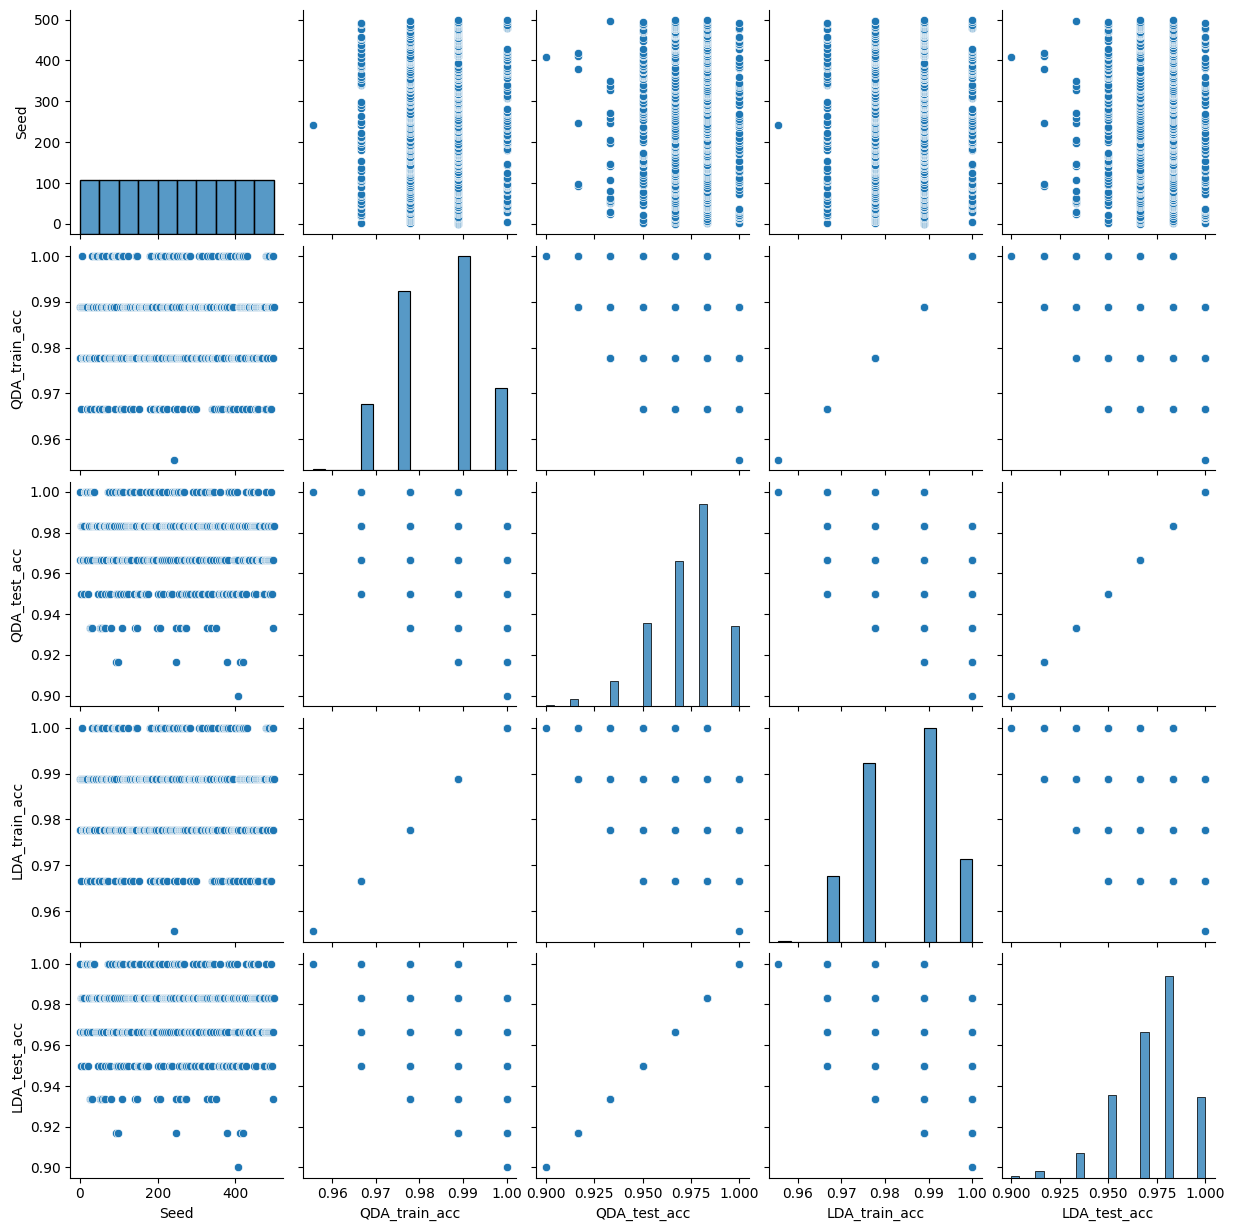

In [24]:
sns.pairplot(r)
plt.show()

- Para este seed, se obtinen los mismos errores que con el caso original. No se ven tampoco cambios entre QDA y LDA de este seed.

## Preguntas técnicas

### Q1: why is there no need for class_to_name?
El diccionario name_to_class es utilizado para mapear nombres de clases a índices de clase. No hay necesidad de un diccionario inverso class_to_name en este contexto específico.
El diccionario inverso class_to_name podría ser útil si necesitaramos realizar operaciones como convertir índices de clases de nuevo a nombres de clases, por ejemplo, al interpretar los resultados de un modelo entrenado que devuelve índices de clases en lugar de nombres de clases directamente.
### Q2: why is reshaping necessary?
El método flatten() convierte el array multidimensional en un array unidimensional, se aplica la función f a cada elemento del array resultante, el reshaping es necesario para darle la dimensión original al array mapeado.
### Q3: what does bincount do?
np.bincount es una función de NumPy que se utiliza para contar las ocurrencias de números enteros no negativos en un array. Es muy útil para encontrar la frecuencia de cada número en un array de enteros no negativos.
En este caso np.bincount se utiliza para determinar la frecuencia de cada una de las clases en y.
### Q4: why do we need to do this last, can't we do it first?
En términos generales, el enfoque de realizar preparaciones iniciales y luego ajustar los parámetros tiene sentido en la mayoría de los casos y sigue una estructura de trabajo común 
Es una buena práctica, en el desarrollo de algoritmos de aprendizaje automático, realizar primero las tareas de preprocesamiento y preparación de datos (como codificación de clases y estimación de probabilidades a priori), luego el ajuste de parámetros y por ultimo las tareas de validación o post-procesamiento. Esta estructura lógica facilita la lectura y comprensión del código.
En el código dado, particular, hay una dependencia de las etiquetas de clase codificadas que se preparan en la primera sentencia: y = self.encoder.fit_transform(y).
### Q5: why not just X[:,y==idx]?
La función flatten() se utiliza para convertir una matriz multidimensional en un array unidimensional. En este contexto, se está utilizando para crear una máscara booleana que filtra las columnas de la matriz X basándose en las etiquetas de clase y, para cada índice idx. La idea detrás de X[:, y.flatten() == idx] es seleccionar las columnas correspondientes a la clase idx en la matriz X usando la máscara booleana creada a partir de y. Esto se hace porque y es una matriz 2D (o al menos es tratada como tal), pero la selección de columnas en X debe ser un array 2D, por lo que flatten() se utiliza para obtener una representación plana de y antes de usarlo como índice para seleccionar las columnas relevantes de X.
No usamos simplemente X[:, y == idx] porque cuando y es un array 2D y se utiliza como índice en X, NumPy no hará la selección correcta de columnas, porque las dimensiones no coinciden. Usando flatten(), se convierte y en un array 1D que puede utilizarse para seleccionar las columnas correctamente.
### Q6: what does bias=True mean? why not use bias=False?
El parámetro bias en la función np.cov controla si se aplica un sesgo (bias) en la estimación de la matriz de covarianza. Cuando bias es True (el valor predeterminado), se divide por N (el número de observaciones) al calcular la covarianza. Cuando bias es False, se divide por N-1, lo que proporciona una estimación no sesgada de la matriz de covarianza (por ejemplo, se utiliza en el cálculo de la matriz de covarianza muestral).
Se usa bias=true porque es un algoritmo de QDA, el cual es un modelo generativo que intenta modelar las distribuciones de probabilidad de las características en cada clase. En este contexto, aplicar un sesgo (dividir por N, el número de observaciones) puede ser apropiado, ya que se está construyendo un modelo basado en distribuciones de probabilidad. La estimación de la matriz de covarianza está vinculada a la forma en que las características se distribuyen en el espacio de características para cada clase.
Además, en QDA se estima una matriz de covarianza diferente para cada clase. Estas matrices de covarianza capturan cómo las características están relacionadas dentro de cada clase. Aplicar un sesgo en la estimación (usando bias=True) puede ayudar a asegurar que las estimaciones de covarianza no sean demasiado sensibles a las fluctuaciones en los datos, lo que podría resultar en una mejor generalización del modelo.
Por último, en algunos conjuntos de datos, las clases pueden tener diferentes tamaños y pueden variar en su cantidad de datos. Aplicar un sesgo puede ayudar a garantizar que la estimación de la matriz de covarianza no se vea influenciada en exceso por clases con un número significativamente menor de observaciones.
### Q7: what does axis=1 mean? why not axis=0 instead?
El parámetro axis=1 se refiere a la dirección a lo largo de la cual se realiza la operación de cálculo de la media. En este caso, axis=1 significa que la operación de cálculo de la media se realizará a lo largo de las filas, es decir, se calculará la media de las características para cada instancia.
Si usáramos axis=0, la operación se realizaría a lo largo de las columnas, lo que daría como resultado las medias de las características a lo largo de las clases, en lugar de las medias de las instancias dentro de cada clase. Esto no sería adecuado en este contexto, ya que estás calculando las medias de las características para cada instancia dentro de cada clase.


## Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.

Sabemos que para LDA $\Sigma_j == \Sigma $:
$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a C. Luego, distribuyendo:
$$
\log{f_j(x)} =  -\frac{1}{2} x^T \Sigma^{-1} x + \frac{1}{2} x^T \Sigma^{-1} \mu_j + \frac{1}{2} \mu_j^T \Sigma^{-1} x - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j + C 
$$

El primer término de la suma es independiente de la clase j, por lo que se puede incorporar a C.
Sabemos que la propiedad de la transpuesta de un producto de matrices $ (AB)^T = B^T A^T $ y que $ (A^T)^T = A $. Por lo tanto:
$$
x^T \Sigma^{-1} \mu_j = ( \mu_j^T (\Sigma^{-1})^T x )^T
$$
Dado que la matríz $\Sigma$ es cuadrada y simétrica, luego $\Sigma ^ -1$ es cuadrada y simétrica, entonces $ (\Sigma^{-1})^T = (\Sigma^{-1})$. Por lo tanto, la ecuación para el logaritmo de la probabilidad resulta:
$$
\log{f_j(x)} =  \frac{1}{2} [\mu_j^T \Sigma^{-1} x ]^T + \frac{1}{2} \mu_j^T \Sigma^{-1} x - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j + C 
$$

Ahora, viendo las dimensiones de las matrices del primer término, tenemos que $\mu_j \epsilon ℝ^{(1xk)}$,  $\Sigma \epsilon ℝ^{(kxk)}$ y  $x \epsilon ℝ^{(kx1)} $, donde k es la cantidad de features del dataset.

Por lo tanto $ [\mu_j^T \Sigma^{-1} x ] $ es un escalar y la ecuación se puede reducir de la siguiente forma:
$$
\log{f_j(x)} =  \frac{1}{2} \mu_j^T \Sigma^{-1} x + \frac{1}{2} \mu_j^T \Sigma^{-1} x - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j + C = \mu_j^T \Sigma^{-1} x - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j + C = \mu_j^T \Sigma^{-1} (x - \frac{1}{2} \mu_j^T) + C
$$

Lo que resulta que, para LDA:
$$
\log{f_j(x)} = \mu_j^T \Sigma^{-1} (x - \frac{1}{2} \mu_j^T) + C
$$

2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".

Tanto LDA (Análisis Discriminante Lineal) como QDA (Análisis Discriminante Cuadrático) son métodos utilizados en la clasificación de patrones. La razón por la que se llaman "lineal" y "cuadrático" se relaciona con la forma en que se modelan las distribuciones de las clases.

Para entender esto, consideremos la expresión general que se busca maximizar en ambos métodos, que está relacionada con la función de densidad de probabilidad ${f_j(x)}$ de una observación x perteneciente a la clase j. Esta expresión implica la matriz de covarianza $\Sigma_j$ y los vectores de medias $\mu_j$ de la clase j.

LDA (Análisis Discriminante Lineal):

En el caso de LDA, asumimos que todas las clases comparten la misma matriz de covarianza $\Sigma_j$, lo que significa que la variabilidad dentro de cada clase es similar. Esto hace que la expresión ${x^T \Sigma^{-1} x}$ sea constante en todas las clases. Por lo tanto, podemos considerar esta parte como un término constante, que se suma a la constante aditiva 
C en la expresión de maximización.
Dado que ${x^T \Sigma^{-1} x}$ es constante y no depende de la clase, la expresión que estamos maximizando solo contiene términos lineales en x. Esto explica por qué se llama "lineal" al LDA. La función ${f_j(x)}$ en LDA es una combinación lineal de las variables x.

QDA (Análisis Discriminante Cuadrático):

En contraste, en el caso de QDA, permitimos que cada clase tenga su propia matriz de covarianza $\Sigma_j$, lo que significa que la variabilidad puede ser diferente para cada clase. Como resultado, el término ${x^T \Sigma^{-1} x}$ ya no es constante, sino que varía entre las clases. Además, debido a esta variabilidad, este término es cuadrático en x, lo que le da a QDA su naturaleza "cuadrática".
La dependencia de la matriz de covarianza en la clase y el término cuadrático en x en la expresión de maximización son las razones por las cuales QDA se llama "cuadrático". La función 
${f_j(x)}$  en QDA es una función cuadrática de las variables x.

En resumen, la diferencia clave entre LDA y QDA radica en cómo se modela la matriz de covarianza y cómo eso afecta la naturaleza lineal o cuadrática de la función de densidad de probabilidad.

3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Esta fórmula involucra la matriz de covarianza ${\Sigma_j}$ y su inversa ${\Sigma_j^{-1}}$. Sin embargo, en el código práctico se utiliza la inversa de la matriz de covarianza ${\Sigma_j^{-1}}$ para calcular los términos relevantes.
La razón por la cual estas dos formas de calcular el resultado son equivalentes radica en una propiedad de las determinantes y sus inversas. La propiedad es la siguiente:
$$ |\Sigma_j| = \frac{1}{|\Sigma_j^{-1}|} = (|\Sigma_j^{-1}|)^{-1} $$ 

Esto significa que el primer término en la fórmula teórica $  -\frac{1}{2}\log |\Sigma_j| = +\frac{1}{2}\log |\Sigma_j^{-1}| $

En la implementación práctica, se utiliza la inversa de la matriz de covarianza ${\Sigma_j^{-1}}$ porque es necesaria para calcular el segundo término de la fórmula. Al usar ${\Sigma_j^{-1}}$​, se evita la necesidad de guardar los valores tanto de ${\Sigma_j}$ como de su inversa ${\Sigma_j^{-1}}$ por separado, lo que simplifica el código y reduce la cantidad de cálculos necesarios.



## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

### Desarrollo

1) Primera capa:

$$
z^{(1)} = \sigma (w^{(1)} \cdot x^{(1)}+b^{(1)})
$$


$$
y^{(1)} = \sigma(z^{(1)})=\sigma
\begin{pmatrix}
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix}
\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}+
\begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix}
\end{pmatrix} =
\begin{pmatrix}
\sigma(
0.1 \cdot 1.8 + (-0.5)\cdot(-3.4) + 0.1)\\
\sigma(
0.3 \cdot 1.8 + (-0.9)\cdot(-3.4) + 0.5)\\
\sigma(
0.8 \cdot 1.8 + (0.02)\cdot(-3.4) + 0.8)
\end{pmatrix} =
\begin{pmatrix}
0.57 \\
-2.61 \\
0.64
\end{pmatrix}
$$

2) Segunda capa:

$$
z^{(1)} = \sigma (w^{(1)} \cdot x^{(1)}+b^{(1)})
$$
$$
z^{(2)} = \sigma (w^{(2)} \cdot y^{(1)}+b^{(2)})
$$

$$
y^{(2)} = \sigma(z^{(2)})=\sigma
\begin{pmatrix}
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix}
\begin{pmatrix}
y^{(2)}[1] \\
y^{(2)}[2] \\
y^{(2)}[3] \\
\end{pmatrix}+
\begin{pmatrix}
0.7
\end{pmatrix}
\end{pmatrix} =
\begin{pmatrix}
\sigma(
-0.4 \cdot 0.57 + 0.6\cdot(-2.61) + (-0.5)\cdot(0.64) + 0.7)\\
\end{pmatrix} =
0.24 
$$

3) Función de Costo:

$$
J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2 = \frac{1}{2}(y^{(2)}-y)^2

$$
Backpropagation:

Derivada de la función de costo con respecto a la salida de la capa de salida:
$$
\frac{∂J}{∂y(2)} = (y^{(2)}-y)

$$
Derivada de ${y(2)}$ con respecto a ${z(2)}$:
$$
\frac{∂y(2)}{∂z(2)} = \sigma' (z^{(2)}) = σ(z^{(2)})\cdot(1−σ(z^{(2)}))

$$
Derivada de ${y(1)}$ con respecto a ${z(1)}$:
$$
\frac{∂y(1)}{∂z(1)} = \sigma' (z^{(1)}) = σ(z^{(1)})\cdot(1−σ(z^{(1)}))

$$
Derivada de ${z(2)}$ con respecto a ${b(2)}$:
$$
\frac{∂z(2)}{∂b(2)} = 1

$$
Derivada de ${z(1)}$ con respecto a ${b(1)}$:
$$
\frac{∂z(1)}{∂b(1)} = 1

$$
Derivada de ${z(2)}$ con respecto a ${w(2)}$:
$$
\frac{∂z(2)}{∂w(2)} = y^{(1)}

$$
Derivada de ${z(1)}$ con respecto a ${w(1)}$:
$$
\frac{∂z(1)}{∂w(1)} = x

$$
Derivada de ${z(2)}$ con respecto a ${y(1)}$:
$$
\frac{∂z(2)}{∂w(2)} = w^{(2)}

$$
Derivada de ${z(1)}$ con respecto a ${x}$:
$$
\frac{∂z(1)}{∂x} = w^{(1)}

$$
Derivadas usando regla de la cadena:
$$
\frac{∂J}{∂w(2)} = \frac{∂J}{∂y(2)} \cdot \frac{∂y(2)}{∂z(2)} \cdot \frac{∂z(2)}{∂w(2)} = (y^{(2)}-y) * \sigma' (z^{(2)}) \cdot  (y^{(1)})^T
$$
$$
\frac{∂J}{∂b(2)} = \frac{∂J}{∂y(2)} \cdot \frac{∂y(2)}{∂z(2)} \cdot \frac{∂z(2)}{∂b(2)} = (y^{(2)}-y) * \sigma' (z^{(2)}) 
$$
$$
\frac{∂J}{∂w(1)} = \frac{∂J}{∂y(2)} \cdot \frac{∂y(2)}{∂z(2)} \cdot \frac{∂z(2)}{∂y(1)} \cdot \frac{∂y(1)}{∂z(1)} \cdot \frac{∂z(1)}{∂w(1)}= (y^{(2)}-y) * \sigma' (z^{(2)}) \cdot w^{(2)} * \sigma' (z^{(1)}) \cdot  x^T
$$
$$
\frac{∂J}{∂w(1)} = \frac{∂J}{∂y(2)} \cdot \frac{∂y(2)}{∂z(2)} \cdot \frac{∂z(2)}{∂y(1)} \cdot \frac{∂y(1)}{∂z(1)} \cdot \frac{∂z(1)}{∂b(1)}= (y^{(2)}-y) * \sigma' (z^{(2)}) \cdot w^{(2)} * \sigma' (z^{(1)})
$$

### Resultados

$$
\frac{∂J}{∂w(2)} = (0.24 - 5) \cdot \frac{1}{1+e^{0.37}} \cdot (1 - \frac{1}{1+e^{0.37}}) \cdot  (y^{(1)})^T = -0.87 \begin{pmatrix}
0.57 & -2.61 & 0.64 
\end{pmatrix} =
\begin{pmatrix}
-0.49 & 2.27 & -0.55 
\end{pmatrix} 
$$

$$
\frac{∂J}{∂b(2)} = -0.87
$$

$$
\frac{∂J}{∂w(1)} = (-0.87) \begin{pmatrix}
-0.4 & 0.2 & -0.5 
\end{pmatrix} \cdot
\begin{pmatrix}
0.24\\
-9.48\\
0.22\\ 
\end{pmatrix} \cdot
\begin{pmatrix}
1.8 & -3.4 
\end{pmatrix} =
\begin{pmatrix}
0.0816\\
1.64\\
0.0957\\ 
\end{pmatrix} \cdot
\begin{pmatrix}
1.8 & -3.4 
\end{pmatrix} = 
\begin{pmatrix}
0.149 & -0.277\\
2.95 & -5.57\\
0.17 & -0.32\\ 
\end{pmatrix}
$$

$$
\frac{∂J}{∂b(2)} = \begin{pmatrix}
0.0816\\
1.64\\
0.0957\\ 
\end{pmatrix} 
$$

